# Exploring Order Dependency in LLMs

While LLMs have demonstrated remarkable capabilities in understanding and generating text, they also exhibit a number of unexpected behavioral patterns. Hallucinations are one well known example, but there are others that are less obvious and more subtle.

In this experiment, we'll explore the *order dependency problem*: a language models' sensitivity to the order of tokens in a sequence. Multiple researchers have shown that small changes to the order that information is presented to a model can make a large difference in the model's response. Like hallucinations, order dependency is a significant obstacle to user acceptance and broader adoption of AI solutions. This is because order dependency leads to inconsistent model outputs, making models seem unreliable and eroding users' trust. Understandably so. For AI solutions to deliver on their promises, they need to be more robust. We can't accept healthcare models that change a diagnosis based on the order a patient's labs are entered. Or financial models that approve or deny loan applications based on who is first or last in line.

One specific area where order dependency has been thoroughly studied is in answering multiple choice questions (MCQs). MCQs are widely used as benchmarks to evaluate LLMs' language understanding and reasoning capabilities. However, multiple researchers have independently shown that simply changing the order the choices are presented can dramatically change a model's score. They've also demonstrated this behavior isn't limited to one or two models, but is a general pattern exhibited the decoder-only Transformer architectures that dominate the current landscape.

We'll spend the rest of this experiment exploring the order dependency problem from multiple viewpoints. First, we'll demonstrate the problem on a tiny sample of MCQs. Next, we'll step back and evaluate the extent of the problem. Next, we'll take a closer look at the leading hypotheses for what's causing the sensitivity and then consider several ways to potentially mitigate the issue.

# Setup

In [1]:
#-------------------------------------------------------------------------------
# Imports
#-------------------------------------------------------------------------------

import logging
import os
from pathlib import Path
from random import sample
from time import perf_counter_ns as timer

from IPython.display import display
from matplotlib import pyplot as plt
from pandas import DataFrame
import seaborn as sns
from tqdm import tqdm

import llama_benchmarks as llb
from llama_benchmarks.models import llama
from llama_benchmarks.mmlu import Question, Questions, Answer, Answers, MMLULlamaGenerator, OPTIONS

In [2]:
#-------------------------------------------------------------------------------
# Parameters
#-------------------------------------------------------------------------------

# Sample size
n_questions = 16

In [3]:
#-------------------------------------------------------------------------------
# Configure Experiment
#-------------------------------------------------------------------------------

# Switch to project root
if os.path.basename(os.getcwd()) == "experiments":
    os.chdir("..")

# Configure logger
logger = logging.getLogger(__name__)

# Path to datasets
datasets_path = Path(".build") / "datasets" 

In [4]:
#-------------------------------------------------------------------------------
# Utility Functions
#-------------------------------------------------------------------------------

def show_questions(questions: Questions):
    display(DataFrame(questions))

# Related Work

The ideas and concepts presented here lean heavily on three research papers published over the past 2 years. Pezeshkpour and Hruschka (2023) studied order dependency in GPT4 (OpenAI et al. 2024) and InstructGPT (Ouyang et al. 2022) and hypothesized the issue was caused by a mixture of uncertainty and *positional bias*. Zheng et al. (2024) studied order dependency in 20 LLMs from 4 popular families and suggested the issue was actually due to *token bias* instead of positional bias. Finally, McIlroy-Young et al. (2024) built on the ideas from the first two papers and recommended a general Set-Based Prompting solution.

# Demonstrating Order Dependency

Let's start by investigating what order dependency looks like in action. We'll start with a random sample of questions from the Massive Multitask Language Understanding (MMLU) (Hendrycks et al. 2021) benchmark dataset. MMLU contains 14,042 MCQs from 57 categories. Each question has 4 options A, B, C, and D and one correct answer. In addition, each category has 5 example questions designed for few-shot experiments.

## MMLU Dataset

In [5]:
# Path to downloaded dataset
mmlu_dataset_path = datasets_path / "mmlu"

# Load a random sample of questions from MMLU
examples, questions = llb.mmlu.load_dataset(mmlu_dataset_path, n_questions=n_questions)
show_questions(questions[0:3])

,category,question,A,B,C,D,answer
0,marketing,What channel structure is it where the produc...,Direct.,Indirect.,Hybrid.,None of the above.,A
1,professional law,A housing corporation owned a tract of land. T...,The rule in Spencer's Case prevents the librar...,The librarian is not in privity of contract wi...,The librarian is not in privity of estate with...,Other lots in the immediate vicinity are used ...,B
2,professional accounting,Which of the following events most likely woul...,Insuring the lives of key executives and listi...,Selling real estate at a price that differs si...,Making a loan with specific scheduled terms fo...,Granting stock options to key executives at fa...,B


Before we move on to the LLMs, we need to clean up the MMLU data a bit. Our goal is to highlight the selection bias inherent to the model. This means we can't give the model any reason to favor one option over another. However, the answers in MMLU are not evenly distributed. To control for this, we'll evenly distribute the answers across the 4 options A, B, C, D in both the example and test questions.

In [6]:
# Sample a category
category = sample(examples, 1)[0].category

# Record initial answer distribution for category
selected_examples = tuple(e for e in examples if e.category == category)
example_distribution1 = llb.mmlu.answer_distribution(selected_examples)
question_distribution1 = llb.mmlu.answer_distribution(questions)

# Debias examples and questions
examples = llb.mmlu.debias_example_answers(examples)
questions = llb.mmlu.debias_question_answers(questions)

# Record debiased answer distribution for category
selected = tuple(e for e in examples if e.category == category)
example_distribution2 = llb.mmlu.answer_distribution(selected)
question_distribution2 = llb.mmlu.answer_distribution(questions)

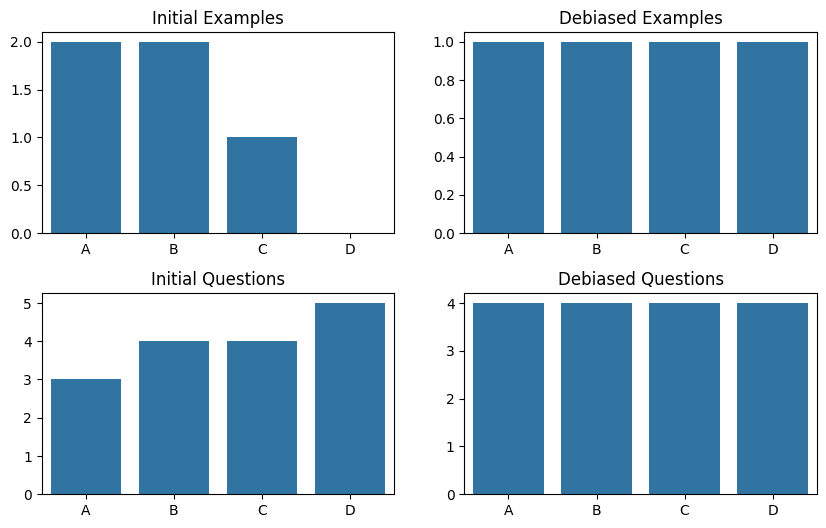

In [7]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10,6))

sns.barplot(example_distribution1, ax=axs[0][0])
axs[0][0].set_title("Initial Examples")

sns.barplot(example_distribution2, ax=axs[0][1])
axs[0][1].set_title("Debiased Examples")

sns.barplot(question_distribution1, ax=axs[1][0])
axs[1][0].set_title("Initial Questions")

sns.barplot(question_distribution2, ax=axs[1][1])
axs[1][1].set_title("Debiased Questions")

fig.subplots_adjust(hspace=0.3)

## Model

Next, we'll run the questions by a Llama 3.2 3B LLM, change the order of the options, answer them with the LLM again, and then see which answers changed. Llama 3.2 3B is a state-of-the-art LLM from Meta that is ideal for local experiments because it's open source and fits on a smaller system with a single GPU.

## Workflow

To quantify the model's accuracy, we'll follow the same MCQ evaluation protocol used by Zheng et al. (2024) and others. We combine each question and relevant examples into a 4-shot prompt and present the prompt to the LLM. Instead of trying to parse the answer from the model's output stream, we extract the logits for tokens "A", "B", "C", "D" from the model's output layer and convert them to probabilities. Not only does this let us quickly identify the model's "answer", it also gives us a direct representation of the model's uncertainty.

To make the analysis easier, we use a custom generator `llama_benchmarks.mmlu.MMLULlamaGenerator` that provides an interface that takes MMLU examples and questions, uses a custom head stage to extracts logits for "A", "B", "C", "D", and avoids all token sampling. This streamlined generator scaffolding is wrapped around the off-the-shelf Llama 3.2 3B model downloaded from Meta (https://www.llama.com/).

In [8]:
config = llama.config("Llama3.2-3B")
config._asdict()

{'device': device(type='mps'),
 'checkpoint_path': PosixPath('/Users/andrewyoung/.llama/checkpoints/Llama3.2-3B'),
 'vocab_size': 128256,
 'd_model': 3072,
 'd_head': 128,
 'd_ffn': 8192,
 'n_layers': 28,
 'n_heads': 24,
 'n_kv_heads': 8,
 'rms_norm_eps': 1e-05,
 'rope_theta': 500000.0,
 'max_seq_len': 8192,
 'temperature': 0.6,
 'top_k': 50,
 'top_p': 0.9,
 'max_completion_tokens': 64}

In [9]:
generator = MMLULlamaGenerator(config)

Next, we'll record the model's accuracy across 5 segments: U, A, B, C, D. The U segment is the initial "uniform" segment where the answers are evenly distributed across all 4 options. The A, B, C, D segments are when the correct answers are shifted entirely to each option. This approach will provide a set of concrete examples we can inspect in more detail and also sets us up to evaluate the model's sensitivity at scale.

In [10]:
results = {}

for segment in ["U", "A", "B", "C", "D"]:
    selected_questions = questions

    # If segment is A, B, C, D swap the answers to the target option
    if segment in OPTIONS:
        selected_questions = llb.mmlu.swap_answers(selected_questions, segment)

    # Answer each question
    start_time = timer()
    answers = tuple(a for a in tqdm(generator(examples, selected_questions), total=n_questions, desc=segment))
    duration = timer() - start_time
    
    # Record performance metrics
    correct = sum(1 for a in answers if a.correct)
    accuracy = correct / n_questions
    rps = 1000000000 * n_questions / duration
    
    results[segment] = {
        "questions": selected_questions,
        "answers": answers,
        "n": n_questions,
        "correct": correct,
        "accuracy": accuracy,
        "rps": rps,
    }

D: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.41it/s]


Text(0.5, 0, 'Segment')

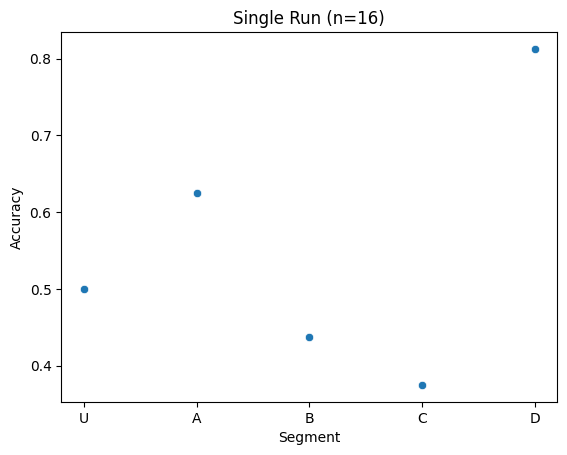

In [11]:
data={k: v["accuracy"] for k, v in results.items()}
ax = sns.scatterplot(data)
ax.set_title(f"Single Run (n={n_questions})")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Segment")

Since the sample is random, the details of the accuracy plot will change with every run but you should see a significant difference in accuracy across the segments.

Note that the model's behavior is completely deterministic here. There is no token sampling happening in the generator. If you rerun the same questions through the model, you'll get the same outputs.

## Error Analysis

Let's take a look at a few questions in detail starting with questions that went from correct to incorrect. These are questions where the model gave you the right answer to begin with, sounded like it knew what it was talking about, and then dropped the ball when the question was modified slightly.

In [12]:
correct_u = {a.qid: a for a in results["U"]["answers"] if a.correct}
incorrect = {
    "A": tuple(a for a in results["A"]["answers"] if a.qid in correct_u and not a.correct),
    "B": tuple(a for a in results["B"]["answers"] if a.qid in correct_u and not a.correct),
    "C": tuple(a for a in results["C"]["answers"] if a.qid in correct_u and not a.correct),
    "D": tuple(a for a in results["D"]["answers"] if a.qid in correct_u and not a.correct),
}

In [13]:
candidates = []
for segment, answers in incorrect.items():
    for answer in answers:
        candidates.append((segment, answer))
candidates = sample(candidates, len(candidates))

In [14]:
it = iter(candidates)

### Incorrect 0

In [15]:
segment, incorrect_answer = next(it)
incorrect_question = results[segment]["questions"][incorrect_answer.qid]
correct_answer = correct_u[incorrect_answer.qid]
correct_question = results["U"]["questions"][correct_answer.qid]

**Correct Question**

In [16]:
print(llb.mmlu.generate_prompt(examples, correct_question, n_shots=0))
print(f"\n{correct_answer.actual}) {getattr(correct_question, correct_answer.actual)}")

The following are multiple choice questions (with answers) about high school microeconomics.

Question: If the market price is above the perfectly competitive firm's average total cost curve, we expect that in the long run,

A) the industry contracts as firms exit the market.
B) the industry expands as firms exit the market.
C) the industry expands as firms enter the market.
D) the industry contracts as firms enter the market.

Answer: 

C) the industry expands as firms enter the market.


**Incorrect Question**

In [17]:
print(llb.mmlu.generate_prompt(examples, incorrect_question, n_shots=0))
print(f"\n{incorrect_answer.actual}) {getattr(incorrect_question, incorrect_answer.actual)}")

The following are multiple choice questions (with answers) about high school microeconomics.

Question: If the market price is above the perfectly competitive firm's average total cost curve, we expect that in the long run,

A) the industry contracts as firms exit the market.
B) the industry expands as firms enter the market.
C) the industry expands as firms exit the market.
D) the industry contracts as firms enter the market.

Answer: 

A) the industry contracts as firms exit the market.


Text(0.5, 1.0, 'Incorrect')

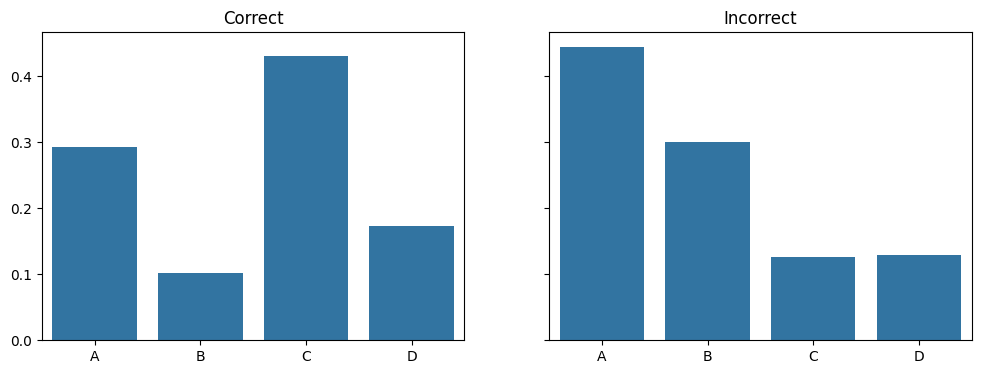

In [18]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(12,4))

sns.barplot(correct_answer.scores, ax=axs[0])
axs[0].set_title("Correct")

sns.barplot(incorrect_answer.scores, ax=axs[1])
axs[1].set_title("Incorrect")

### Incorrect 1

In [19]:
segment, incorrect_answer = next(it)
incorrect_question = results[segment]["questions"][incorrect_answer.qid]
correct_answer = correct_u[incorrect_answer.qid]
correct_question = results["U"]["questions"][correct_answer.qid]

**Correct Question**

In [20]:
print(llb.mmlu.generate_prompt(examples, correct_question, n_shots=0))
print(f"\n{correct_answer.actual}) {getattr(correct_question, correct_answer.actual)}")

The following are multiple choice questions (with answers) about high school microeconomics.

Question: If the market price is above the perfectly competitive firm's average total cost curve, we expect that in the long run,

A) the industry contracts as firms exit the market.
B) the industry expands as firms exit the market.
C) the industry expands as firms enter the market.
D) the industry contracts as firms enter the market.

Answer: 

C) the industry expands as firms enter the market.


**Incorrect Question**

In [21]:
print(llb.mmlu.generate_prompt(examples, incorrect_question, n_shots=0))
print(f"\n{incorrect_answer.actual}) {getattr(incorrect_question, incorrect_answer.actual)}")

The following are multiple choice questions (with answers) about high school microeconomics.

Question: If the market price is above the perfectly competitive firm's average total cost curve, we expect that in the long run,

A) the industry contracts as firms exit the market.
B) the industry expands as firms exit the market.
C) the industry contracts as firms enter the market.
D) the industry expands as firms enter the market.

Answer: 

C) the industry contracts as firms enter the market.


Text(0.5, 1.0, 'Incorrect')

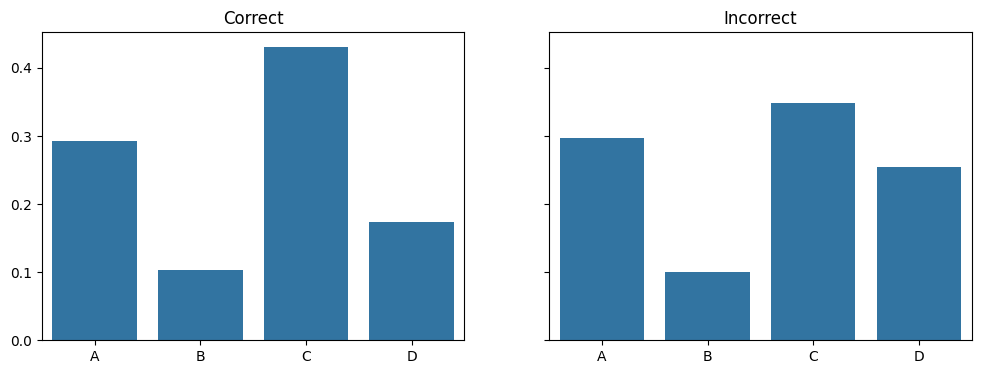

In [22]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(12,4))

sns.barplot(correct_answer.scores, ax=axs[0])
axs[0].set_title("Correct")

sns.barplot(incorrect_answer.scores, ax=axs[1])
axs[1].set_title("Incorrect")

### Incorrect 2

In [23]:
segment, incorrect_answer = next(it)
incorrect_question = results[segment]["questions"][incorrect_answer.qid]
correct_answer = correct_u[incorrect_answer.qid]
correct_question = results["U"]["questions"][correct_answer.qid]

**Correct Question**

In [24]:
print(llb.mmlu.generate_prompt(examples, correct_question, n_shots=0))
print(f"\n{correct_answer.actual}) {getattr(correct_question, correct_answer.actual)}")

The following are multiple choice questions (with answers) about high school mathematics.

Question: Where, in the first quadrant, does the rose r = sin 3θ have a vertical tangent?

A) nowhere
B) θ=  0.47
C) θ = 0.39
D) θ = 0.52

Answer: 

B) θ=  0.47


**Incorrect Question**

In [25]:
print(llb.mmlu.generate_prompt(examples, incorrect_question, n_shots=0))
print(f"\n{incorrect_answer.actual}) {getattr(incorrect_question, incorrect_answer.actual)}")

The following are multiple choice questions (with answers) about high school mathematics.

Question: Where, in the first quadrant, does the rose r = sin 3θ have a vertical tangent?

A) nowhere
B) θ = 0.52
C) θ = 0.39
D) θ=  0.47

Answer: 

B) θ = 0.52


Text(0.5, 1.0, 'Incorrect')

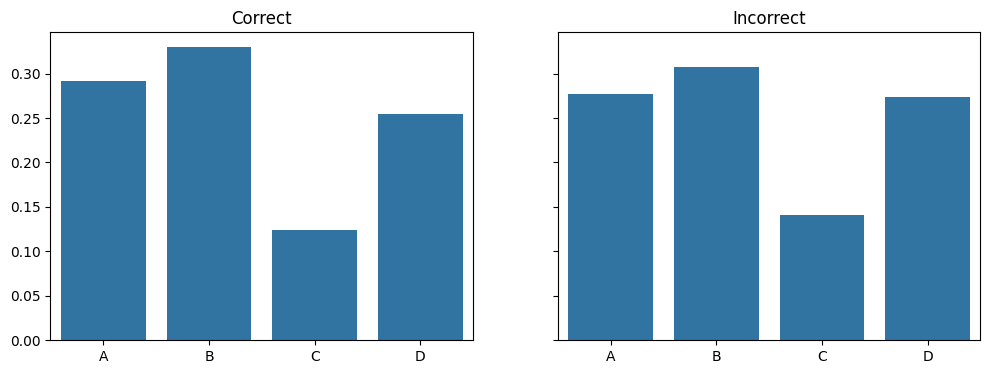

In [26]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(12,4))

sns.barplot(correct_answer.scores, ax=axs[0])
axs[0].set_title("Correct")

sns.barplot(incorrect_answer.scores, ax=axs[1])
axs[1].set_title("Incorrect")

## Key Observations

One anecdotal pattern that immediately stands out is the model seems to stick with the original option even after we switched the answers. It's as if the model simply guessed correctly the first time and then stuck with the same guess the second time.

# Quantifying Order Dependency

# Exploring Potential Order Dependency Causes

# Mitigating Order Dependency

# References

Almazrouei, Ebtesam, Hamza Alobeidli, Abdulaziz Alshamsi, Alessandro Cappelli, Ruxandra Cojocaru, Mérouane Debbah, Étienne Goffinet, et al. 2023. “The Falcon Series of Open Language Models.” arXiv. https://doi.org/10.48550/arXiv.2311.16867.

Dubey, Abhimanyu, Abhinav Jauhri, Abhinav Pandey, Abhishek Kadian, Ahmad Al-Dahle, Aiesha Letman, Akhil Mathur, et al. 2024. “The Llama 3 Herd of Models.” arXiv.Org. July 31, 2024. https://arxiv.org/abs/2407.21783v2.

Hendrycks, Dan, Collin Burns, Steven Basart, Andy Zou, Mantas Mazeika, Dawn Song, and Jacob Steinhardt. 2021. “Measuring Massive Multitask Language Understanding.” arXiv. https://doi.org/10.48550/arXiv.2009.03300.

Liusie, Adian, Potsawee Manakul, and Mark J. F. Gales. 2024. “LLM Comparative Assessment: Zero-Shot NLG Evaluation through Pairwise Comparisons Using Large Language Models.” arXiv. https://doi.org/10.48550/arXiv.2307.07889.

McIlroy-Young, Reid, Katrina Brown, Conlan Olson, Linjun Zhang, and Cynthia Dwork. 2024. “Set-Based Prompting: Provably Solving the Language Model Order Dependency Problem.” arXiv. https://doi.org/10.48550/arXiv.2406.06581.

OpenAI, Josh Achiam, Steven Adler, Sandhini Agarwal, Lama Ahmad, Ilge Akkaya, Florencia Leoni Aleman, et al. 2024. “GPT-4 Technical Report.” arXiv. https://doi.org/10.48550/arXiv.2303.08774.

Ouyang, Long, Jeff Wu, Xu Jiang, Diogo Almeida, Carroll L. Wainwright, Pamela Mishkin, Chong Zhang, et al. 2022. “Training Language Models to Follow Instructions with Human Feedback.” arXiv. https://doi.org/10.48550/arXiv.2203.02155.

Pezeshkpour, Pouya, and Estevam Hruschka. 2023. “Large Language Models Sensitivity to The Order of Options in Multiple-Choice Questions.” arXiv. https://doi.org/10.48550/arXiv.2308.11483.

“Vicuna: An Open-Source Chatbot Impressing GPT-4 with 90%* ChatGPT Quality | LMSYS Org.” n.d. Accessed November 7, 2024. https://lmsys.org/blog/2023-03-30-vicuna.

Zheng, Chujie, Hao Zhou, Fandong Meng, Jie Zhou, and Minlie Huang. 2024. “Large Language Models Are Not Robust Multiple Choice Selectors.” arXiv. https://doi.org/10.48550/arXiv.2309.03882.